<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Jorge Allendes
- Valentina Castro


### **Link de repositorio de GitHub:** `https://github.com/J07Aa/Repo`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [42]:
len(df)

70692

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [2]:
!pip install xgboost

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [4]:
df.columns

Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')

In [5]:
#df.describe()

In [6]:
# Para determinar de forma rápida que columnas normalizaremos, utilizamos "describe"
# Con esto podemos ver que hay varias columnas que podrían perfectamente ser booleanos, 
# solo tienen 1's y 0's, es por esto que estas columnas no serán normalizadas. 
# Por otro lado si normalizaremos columnas con mayor rango de datos y utilizaremos el clásico
# MinMax()
column_transformer = ColumnTransformer(transformers=[
    ('numeric' , MinMaxScaler(), ['Age', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth'])
    ],remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('classifier', XGBClassifier())
])
X = df.copy()[['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP']]
y = df.copy()[['Diabetes']]

pipeline.fit(X, y)
predictions_xgb = pipeline.predict(X)
mae_xgb = mean_absolute_error(y, predictions_xgb)
print(f'MAE con XGBRegressor: {mae_xgb}')

MAE con XGBRegressor: 0.22383013636620833


In [7]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

In [8]:
# Ahora vemos más a fondo como se comporta el modelo
accuracy = accuracy_score(y, predictions_xgb)
precicion =precision_score(y, predictions_xgb)
recall = recall_score(y, predictions_xgb)
f1score = f1_score(y, predictions_xgb)
print(f'Exactitud: {accuracy}') # (TP+TN)/Total
print(f'Precision: {precicion}') # TP/(TP+FP)
print(f'Recall: {recall}') # TP/(TP+FN)
print(f'F1-Score: {f1score}')

Exactitud: 0.7761698636337917
Precision: 0.754517247672933
Recall: 0.8187065014428789
F1-Score: 0.7853023785940106


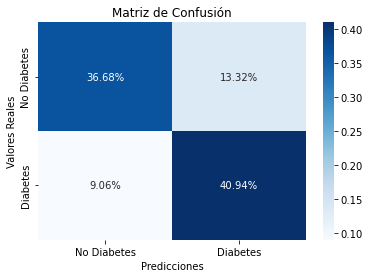

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y, predictions_xgb, normalize='all')
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Observando las metricas que nos dá el reporte, es posible ver que centrandonos en los casos que nos interesa (Classification =1), se tiene una menor precisión al detectar diabetes que al no detectarla. PAra este tipo de estudios es necesario evaluar bien los costos de falsos positivos y negativos, así como tambien TP y TN. En nuestro juicio sería más importante detectar de forma correcta la mayor cantidad de gente con diabetes para de esta forma comenzar el tratamiento de forma temprana, dando un gran valor a los TP y castigando los FN. De todas maneras no queremos que nuestro algoritmo clasifique a todos como diabeticos para de esta manera asegurarnos que detectamos a los diabético, tambien hay que dar importancia a los TN y FP, aunque a nuestro pareces si podríamos permitir un mayor porcentaje de error en estos últimos.
De la métrica recall vemos que del total de casos positivos se clasifican de forma correcta un 81% y por ende hay un porcentaje importante (20%) de gente que tiene diabetes y no se es avisada. De la exactitud vemos que en general el modeloacierta el 77% de las veces. Consideramos que se podría buscar mejorar el recall para disminuir los falsos negativos. 

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

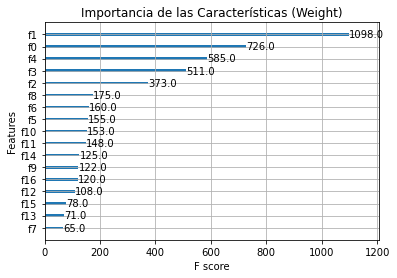

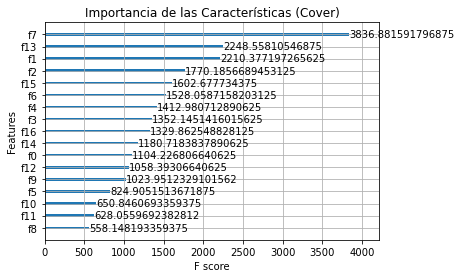

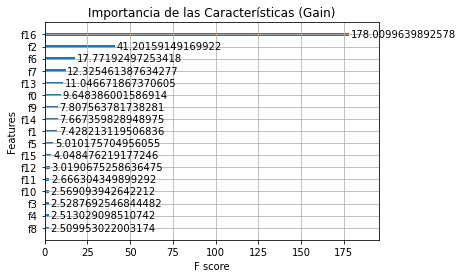

In [10]:
# Inserte su código aquí
import xgboost as xgb
xgb_model = pipeline.named_steps['classifier']
# Plotear la importancia de las características usando plot_importance

xgb.plot_importance(xgb_model, importance_type='weight', title='Importancia de las Características (Weight)')
plt.show()

xgb.plot_importance(xgb_model, importance_type='cover', title='Importancia de las Características (Cover)')
plt.show()

xgb.plot_importance(xgb_model, importance_type='gain', title='Importancia de las Características (Gain)')
plt.show()


En weigth vemos que la caracteristicas más importantes son: f0,f1,f4 y f10, que vendrían siendo Edad, Sexo, BMI y 
HvyAlcoholConsump respectivamente, lo que nos indica que es normal que estás características aparescan en los arboles para 
realizar una decisión.
En cuanto a cover, las caracte´risticas más importantes son: f7,f13,f1 y f2 que vendrían siendo  PhysActivity, 
PhysHlth, sexo y HighChol lo que nos indica que la mayoría de los datos utilizan esas características en alguna desición, 
lo que da importancia  a la actividad y salud ficica, sumado al colesterol.
Finalmente en cuanto a Gain hay solo 2 características que se escapan de las demás HighBP (intuinmos que es presión en sangre) 
y HighChol un alto colesterol. Siendo estas características buenas ya que mejoran el desempeño de los árboles.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [11]:
# Inserte su código aquí
from sklearn.inspection import permutation_importance
import numpy as np

In [12]:
clf = xgb_model
result = permutation_importance(clf, X, y, n_repeats=30, random_state=42)

In [13]:
#result

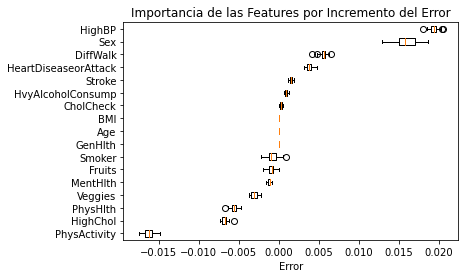

In [14]:
# Obtener las importancias y desviaciones estándar
importances = result.importances_mean
std_devs = result.importances_std

# Visualizar la importancia de las características
features = X.columns
indices = np.argsort(importances)

perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(features)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

 - La desviación  estandar de estos resultados nos indica que tan precisa es la importancia de una feature.
 - La importancia de las features se obtiene utilizando el modelo ya entrenado y modificando la posición de las feature, 
si esto no presenta un efecto importante, entoces la features no son tan importantes, pero si el cambio de las features 
lleva a cambios en los resultados entonces la feature tiene importancia.  
 - Las features importantes resultan ser: HighBP (alta presión de sangre), Sexo, ,DiffWalk, HeartDiseaseorAttack y stroke, 
atributos como actividad física (PhysActivity), el indicador de altó colesterol (HighChol) y PhysHlth (salud física), 
presentan un infdicador alto en módulo, más negativo, es nos hace pensar que es nesaecario mencionar que hay features que
aparentemente frenan el desempeño del modelo al estar presentes. Cambian levemente lás características más importantes
respecto con la sección anterior, más hay un grupo que se mantiene y fortalece el trabajo realizado anteriormente.
 - No cambian considerablemente las conclusiones ya que solo se agrega información que respalda las features más importantes como 
HighBP, Sexo, HeartDiseaseorAttack. Y llama la atención la paracición de features que se ocnsideraban importantes entre las 
menos importantes con valores negativos lo que indicaría que la importancia que se detectava anteirormente era debido al freno 
que ponian en el desempeño de loa modelos.

- Ventajas: Se reutiliza el modelo ya entenado.
            Es de fácil interpretación y comprensión.
            Toma en cuenta iteraciones lo que permitiría una mejor calibración.
- Desventajas: El utilizar el modelo nos enlaza a el error del mismo.
            Para features correlacionadas se podrían generar sesgos por entradas poco realistas.
            Al haber correlación de features se podría disminuir l aimportancia de un atributo al separar otros dos.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [15]:
#pip install numpy>=1.22
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/b0/dd/f233bb4bac8d083c5bb0c79e9e19541a580daff1dd5381e1f2e7486cc25e/shap-0.43.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.4/445.4 kB 9.2 MB/s eta 0:00:00:00:01


In [16]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [17]:
# Inserte código para calcular shapley values aquí

import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

shap.initjs()  
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])
# Visualización alternativa de SHAP values para la primera observación
#shap.summary_plot(shap_values, X, plot_type="bar")



[22:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

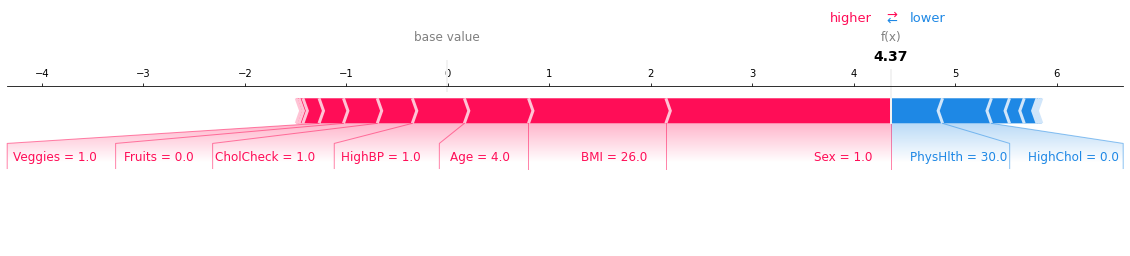

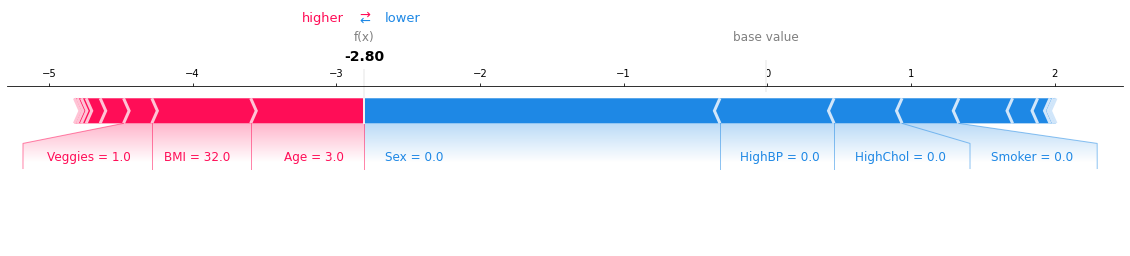

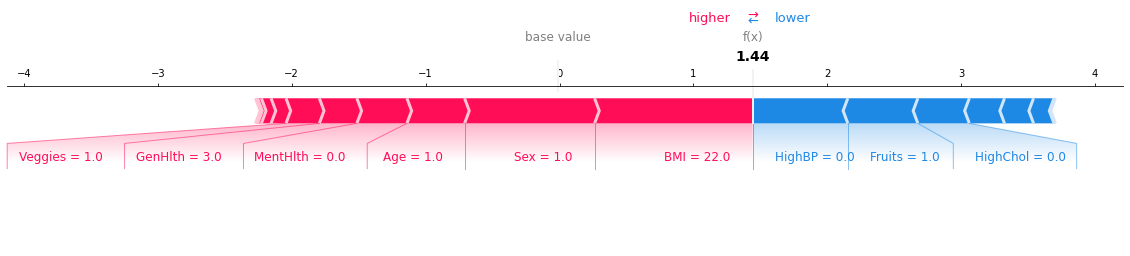

In [18]:
# Instancia 1
instancia = 0  
shap.force_plot(
    explainer.expected_value, 
    shap_values[instancia], 
    X.iloc[instancia], 
    matplotlib=True
)
plt.show()

# Instancia 9
instancia = 8
shap.force_plot(
    explainer.expected_value, 
    shap_values[instancia], 
    X.iloc[instancia], 
    matplotlib=True
)
plt.show()

# Instancia 150
instancia = 149
shap.force_plot(
    explainer.expected_value, 
    shap_values[instancia], 
    X.iloc[instancia], 
    matplotlib=True
)
plt.show()


    Variables que Afectan la Probabilidad de Tener Diabetes:
        En la primera instancia, las características como el BMI y la categoría de Sexo aumentan la probabilidad de diabetes (efecto positivo), mientras que PhysHlth y HighChol tienen un efecto negativo.
        En la segunda instancia, BMI nuevamente muestra un efecto positivo, y Sex tiene esta vez un efecto negativo.
        En la tercera instancia, Age y BMI muestran efectos positivos, mientras que HighBP y Fruits muestran efectos negativos.

    Patrones Comunes:
        BMI aparece como positivo en todas las instancias, lo cual está alineado con la teoría que asocia un mayor BMI con un mayor riesgo de diabetes.
        El Sexo parece tener un efecto variable, lo cual lleva a pensar que la representación de esta variable tiene una complejidad que no se entiende completamente en un único valor SHAP.
        Otras variables como HighBP y HighChol muestran efectos tanto positivos como negativos en diferentes instancias, lo que indica que su contribución a la predicción puede depender del contexto. 

    Generalización a Todo el Dataset:
         Si bien podemos observar que ciertas características como BMI tienden a tener una influencia positiva consistente en la probabilidad de diabetes, no podemos afirmar que este será el caso para todas las instancias en el conjunto de datos sin un análisis mas profundo.


### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

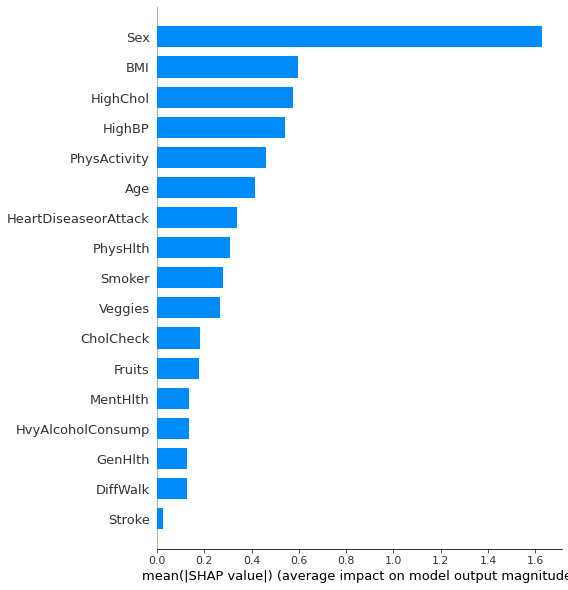

In [19]:
# Inserte código para generar gráficos de aporte global aquí


shap.summary_plot(shap_values, X, plot_type='bar')

Las visualizaciones de valores SHAP a nivel de instancia y global proporcionan perspectivas diferentes pero que de alguna forma se complementan. Los valores SHAP individuales detallan cómo cada característica influye en la predicción para una observación particular, y por otro lado, el análisis global, ofrece una vista que resalta las características más influyentes en general en el modelo. 

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [26]:
# obtenemos los shap values
shap_values = explainer(X)
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X.columns[shap_values_abs.argsort()[:5]]

In [27]:
feature_importance_names

Index(['Stroke', 'DiffWalk', 'GenHlth', 'HvyAlcoholConsump', 'MentHlth'], dtype='object')

In [28]:
shap_values

.values =
array([[ 0.63209605,  2.2190194 , -0.4811471 , ..., -0.02355053,
        -0.02301551,  0.5127283 ],
       [ 0.38928112,  0.2612816 ,  0.59256923, ...,  0.22318502,
        -0.16707808,  0.5243336 ],
       [ 0.7437954 ,  1.3126781 , -0.5089054 , ..., -0.00954743,
        -0.01985349, -0.6679075 ],
       ...,
       [ 0.01368385, -1.9035954 ,  1.0450518 , ...,  0.06506088,
        -0.01208848,  0.5557737 ],
       [-0.14841136, -1.9426496 ,  0.6516575 , ...,  0.1080156 ,
        -0.02888207,  0.5610719 ],
       [ 0.04433898, -2.0940092 ,  0.92545986, ..., -0.05054354,
        -0.01226173,  0.44624662]], dtype=float32)

.base_values =
array([-0.00915477, -0.00915477, -0.00915477, ..., -0.00915477,
       -0.00915477, -0.00915477], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.

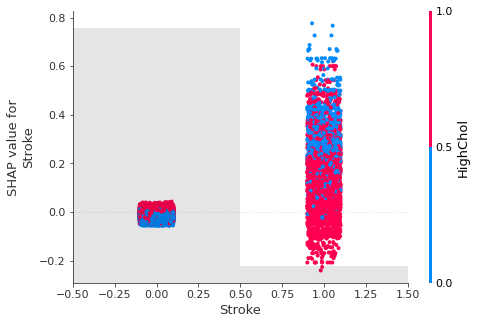

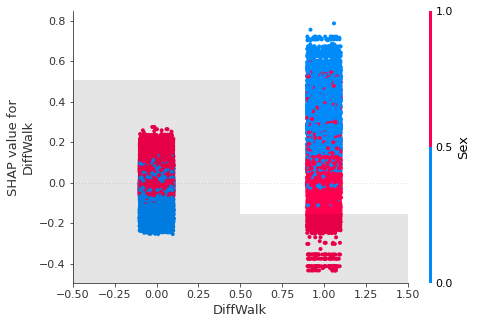

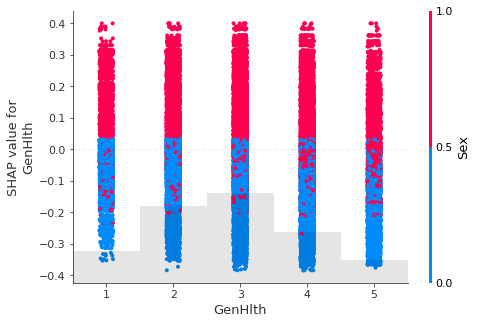

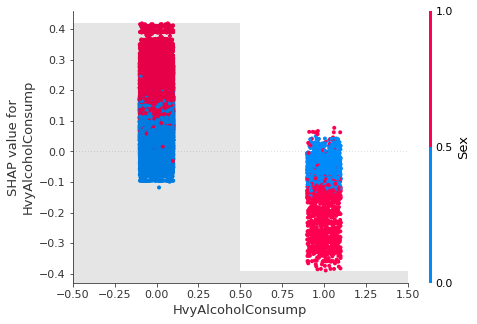

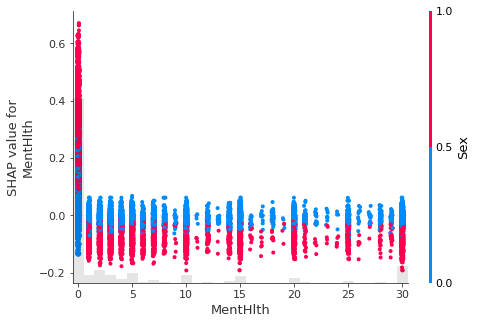

In [39]:
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                   color=shap_values)

Se ve que mayoría de los gráficos presentan una acumulación de puntos a lo largo de un valor específico, y uno de ellos (el de GenHlth) tiene una dispersión más amplia, lo que implica una relación más compleja y posiblemente no lineal del GenHlth en el modelo. 

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [40]:
# Inserte código para generar gráficos PDP aquí
# Submuestrear 1000 observaciones (ajusta según el tamaño de tu conjunto de datos)
# obtenemos los shap values
shap_values = explainer(X)
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X.columns[shap_values_abs.argsort()[:5]]
X1000 = shap.utils.sample(X, 1000)


Stroke


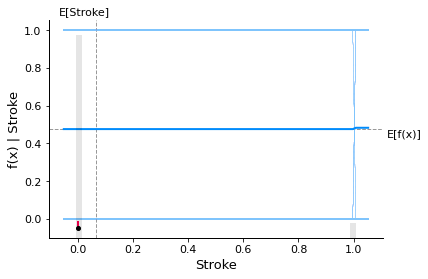

DiffWalk


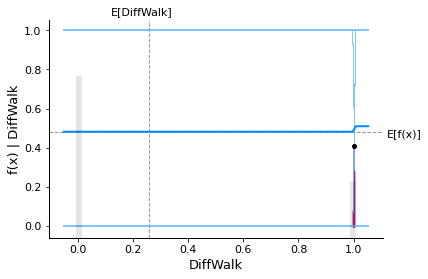

GenHlth


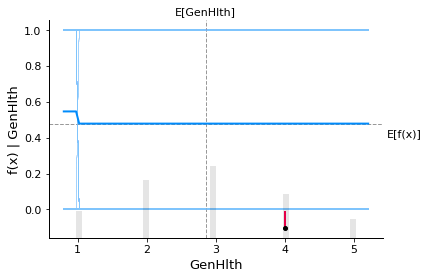

HvyAlcoholConsump


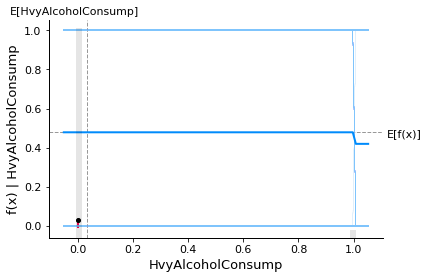

MentHlth


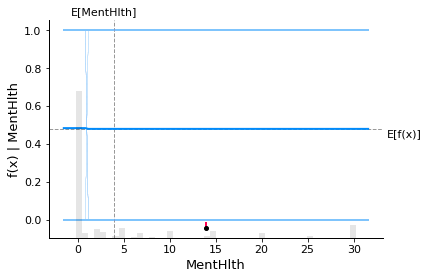

In [41]:
for name in feature_importance_names[:5]:
    print(name)
    shap.partial_dependence_plot(
        f'{name}', clf.predict, X1000, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[100:101,:])

Como varias características, toman unicamente valores 1's y 0's, es entendible que la curva PDP no varíe mucho dentro de ese rango ya que no existen muestras dentro del mismo, mas cuando está en los límites si hay cambios en la probabilidad. De todas maneras este análisis no toma en cuenta como interactuan las variables respecto a laos cambios. Para que estos resultados sean generalizables, habría que tener una mayor porcion de los datos, de manera que la muestra no esté desbalanceada y represente atodos los datos de forma correcta.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [24]:
!pip install alibi

     |████████████████████████████████| 524 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 474 kB/s eta 0:00:011
     |████████████████████████████████| 10.2 MB 205 kB/s eta 0:00:01
     |████████████████████████████████| 115 kB 74.9 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 53.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.9 MB 32.3 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 49.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 932 kB 26.9 MB/s eta 0:00:01
     |████████████████████████████████| 381 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 494 kB 41.9 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 13.1 MB/s eta 0:00:01
     |██████████████████████████████

In [25]:
from alibi.explainers import AnchorTabular

2023-11-24 21:57:22.168600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2023-11-24 21:57:22.169085: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [31]:
# Inserte su código para generar sistema de reglas aquí

explainer = AnchorTabular(xgb_model.predict, feature_names=X.columns.tolist())

explainer.fit(X.values, disc_perc=[25, 50, 75])

instancias = [1000, 3001, 5751]
exp = []
for idx in instancias:
    x = X.iloc[idx].values.reshape(1, -1)
    explanation = explainer.explain(x, threshold=0.95)
    exp.append(explanation)

for idx, explanation in zip(instancias, exp):
    print(f'Reglas para instancia {idx}:')
    print('Anchor: %s' % (' Y '.join(explanation.anchor)))
    print('Precision: %.2f' % explanation.precision)
    print('Coverage: %.2f' % explanation.coverage)
    print('\n')

Reglas para instancia 1000:
Anchor: Sex > 0.00 Y PhysActivity > 0.00
Precision: 1.00
Coverage: 0.33


Reglas para instancia 3001:
Anchor: Sex <= 0.00 Y HighBP <= 0.00
Precision: 0.98
Coverage: 0.25


Reglas para instancia 5751:
Anchor: Sex <= 0.00 Y HighBP <= 0.00
Precision: 1.00
Coverage: 0.24




Las reglas generadas indican que las características de sexo y actividad física son los predictores clave en la decisión del modelo para ciertas instancias con una precisión casi perfecta. Sin embargo, estas reglas son aplicables a un cuarto a un tercio del conjunto de datos, esto derivado desde los valores de la cobertura. 

Así, aunque las reglas entregan explicaciones fiables, no capturan la totalidad del modelo ni pueden explicar todas las predicciones. Por esto, podemos decir que el modelo utiliza muchas características y combinaciones para hacer predicciones, y que las reglas que se proporcionan son aplicables solo algunas partes de la población.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

Los métodos que permitén entregr mejores conclusiones a nuestro arecer son los globales, ya que tomana en cuenta la interacción entre variables y muestran de mejor manera como funciona el modelo en general, teniendo en cuenta todas sus partes y desiciones.
Para el problema del doctor Simi consideramos que sería mejor utilizar los métodos globales, ya que con los métodos locales nos centramos en una sola varibale y perdemos de vista la interacción con las demás, por otro lado los métodos globales toman en cuenta todos los atributos. De todas manera siempre es recomendable utilizar ambos métodos ya que se puede extraer información importante del modelo y el trasfondo de la solución

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>